Macarena Benjamin

## Objetivo

Desarrollar un pipeline de clasificación de imágenes satelitales utilizando el dataset EuroSAT, explorando distintas estrategias de extracción de características mediante modelos preentrenados y arquitecturas avanzadas.

## Consigna: Comparación de Enfoques para la Clasificación de Uso y Cobertura del Suelo
Seleccioná al menos dos enfoques distintos para abordar la tarea de clasificación de imágenes satelitales del dataset EuroSAT. Uno de los enfoques deberá ser un modelo propio basado en redes neuronales convolucionales (CNN) y el otro, una arquitectura preentrenada moderna.

**Enfoque 1: Modelo CNN clásico (obligatorio)**  
Diseñá e implementá un modelo simple basado en capas Conv2D, MaxPooling2D y capas densas (Dense).

Ajustá los hiperparámetros (número de filtros, tamaño de kernel, funciones de activación, etc.).

Entrená el modelo sobre las imágenes del dataset EuroSAT.  
Evaluá el desempeño del modelo con el conjunto de validación.

**Enfoque 2: Modelo preentrenado (a elección)**  
Seleccioná un modelos preentrenados para usarlo como extractor de embeddings. Se sugiere revisar la documentación de estos modelos y y el material de las clases para seleccionar uno de ellos.

* ResNet50 (Keras)
* EfficientNetB0 (Keras)
* MobileNetV2 (Keras)
* ViT (Vision Transformer, vía HuggingFace Transformers)

Utilizá la salida del modelo preentrenado como entrada a una o más capas densas para realizar la clasificación.  
Evaluá el desempeño del modelo con el conjunto de validación.

## Ejes principales del trabajo

1. **Exploración del dataset EuroSAT.**
2. **Preprocesamiento de imágenes.**
3. **Clasificación con modelo propio CNN.**
4. **Clasificación con modelos preentrenados (ResNet, EfficientNet, ViT, etc.).**
5. **Evaluación de desempeño (accuracy, matriz de confusión, visualización).**
6. **Conclusiones comparativas.**

**APELLIDO Y NOMBRE: BENJAMIN MACARENA**

# **Introduccion al set de datos**

Los datos se obtienen de los sitios:  https://www.kaggle.com/datasets/apollo2506/eurosat-dataset y https://github.com/phelber/EuroSAT . El dataset EuroSAT es un conjunto de imágenes satelitales recopiladas a partir de datos del satélite Sentinel-2 de la Agencia Espacial Europea (ESA). Este dataset fue desarrollado para apoyar la **clasificación automática del uso del suelo y la cobertura terrestre en Europa**. Las imágenes están etiquetadas en diferentes **categorías** que representan **distintos tipos de uso del suelo**, como áreas residenciales, tierras agrícolas, bosques, entre otros. EuroSAT es ampliamente utilizado en tareas de aprendizaje automático y visión por computadora relacionadas con teledetección y monitoreo ambiental.


El dataset busca facilitar la clasificación automática del uso y cobertura del suelo a partir de imágenes satelitales multiespectrales. Esto es clave para aplicaciones como la planificación urbana, la agricultura de precisión y la vigilancia ambiental.

El dataset contiene un total de 27,000 imágenes. Hay 10 clases, que representan diferentes tipos de uso del suelo:

* Residential
* Industrial
* River
* Annual Crop
* Permanent Crop
* Pasture
* Herbaceous Vegetation
* Highway
* Forest
* Sea/Lake


Las imágenes tienen una resolución espacial de 64x64 píxeles y están organizadas en carpetas por clase, es decir, hay una carpeta para cada una de las 10 clases, y dentro de cada carpeta se encuentran las imágenes correspondientes a esa clase. Esto facilita el uso del dataset con bibliotecas como PyTorch o TensorFlow, que pueden cargar datos organizados de este modo.

Para las mismas se utilizó el sensor multiespectral del satélite Sentinel-2, que captura imágenes en 13 bandas espectrales diferentes. El dataset EuroSAT se enfoca en una versión RGB (3 bandas) y una versión multiespectral con 13 bandas.

Se puede inferir que aunque las clases están relativamente balanceadas, hay ligeras variaciones en el número de imágenes por clase. Por ejemplo, algunas clases como "Annual Crop" tienen más imágenes que otras como "Sea/Lake". Sin embargo, el desbalance no es extremo y el dataset es considerado razonablemente balanceado para tareas de clasificación supervisada.

# **Extraccion de los datos**

In [3]:
#Importación de Librerías
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from sklearn.metrics import classification_report
import os


In [4]:
# Cargar EuroSAT desde TensorFlow Datasets
# Se separan los datos para 80% de entrenamiento y 20% de testeo

import tensorflow_datasets as tfds
(ds_train, ds_test), ds_info = tfds.load(
    'eurosat/rgb',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.POF4R4_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


Forma de las imágenes: (64, 64, 3)
Número de clases: 10
Etiquetas: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


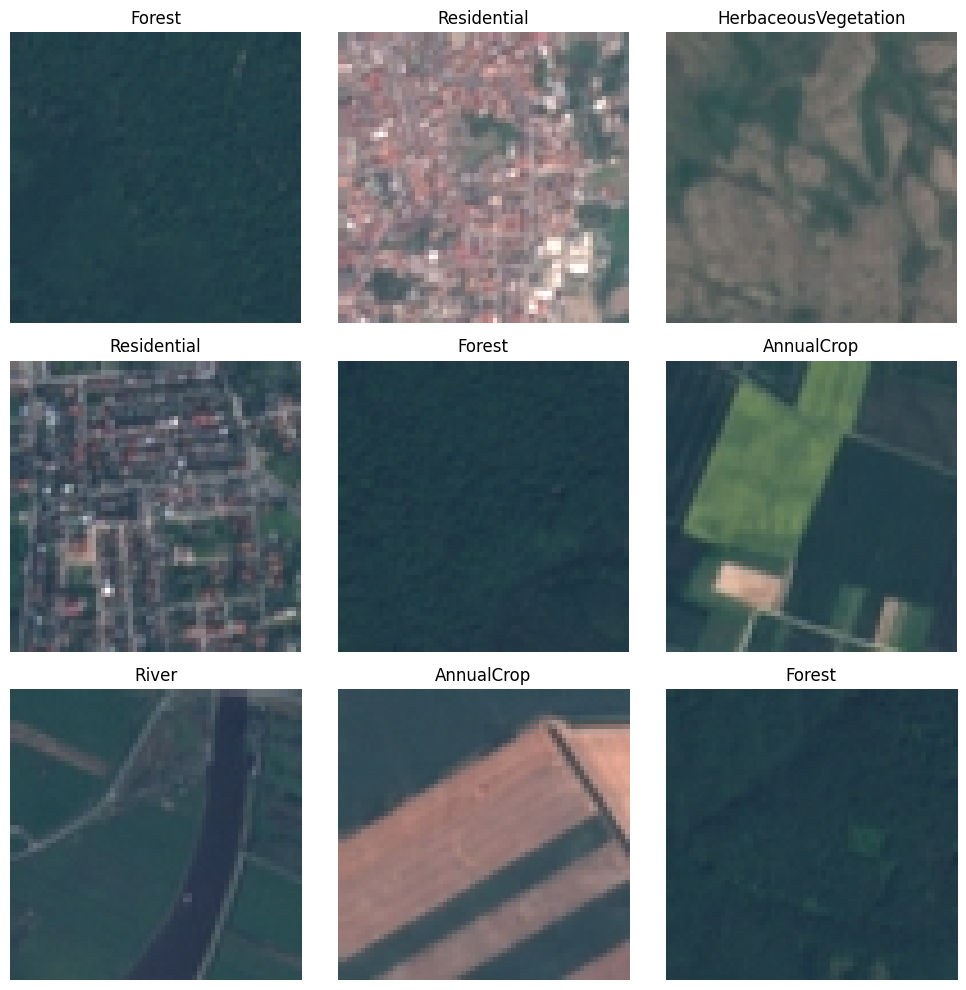

In [24]:
# Mostrar las dimensiones de las imágenes
print("Forma de las imágenes:", ds_info.features['image'].shape)
print("Número de clases:", ds_info.features['label'].num_classes)
print("Etiquetas:", ds_info.features['label'].names)

# Mostrar algunas imágenes de entrenamiento
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.numpy())
    plt.title(ds_info.features['label'].int2str(label.numpy()))
    plt.axis("off")
plt.tight_layout()
plt.show()

# **Preprocesamiento de las imagenes**

Pasos:
- Se separó en el paso anterior los datos en 80% entrenamiento y 20% testeo.
- Convertir las imágenes a float32 y normalizar a [0, 1].
- Usar shuffle para evitar sesgos de orden.
- Usar batch para agrupar imágenes (32 por lote).
- Usar prefetch para acelerar el entrenamiento aprovechando múltiples hilos.

In [28]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Nombres de las clases
class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes
image_shape = ds_info.features['image'].shape

# Función de preprocesamiento: normaliza los píxeles de 0–255 a 0–1
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Parámetros del pipeline
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Aplicar el preprocesamiento y crear el pipeline
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(AUTOTUNE)


# **Modelo CNN**

Este modelo se conforma una **red neuronal convolucional (CNN)** construida con una arquitectura secuencial compuesta por:

1. **Capa de entrada (Input)**: recibe imágenes con forma `(64, 64, 3)`, es decir, 64 píxeles de alto y ancho y 3 canales (RGB).

2. **Primera capa convolucional (Conv2D)**: utiliza 32 filtros de tamaño 3x3 y la función de activación **ReLU** (Rectified Linear Unit), que introduce no linealidad. Esta capa extrae características locales simples como bordes y texturas.

3. **Capa de pooling (MaxPooling2D)**: reduce la dimensionalidad espacial con un filtro de 2x2, manteniendo las características más importantes. Esto ayuda a reducir el cómputo y prevenir sobreajuste.

4. **Segunda capa convolucional**: aplica 64 filtros 3x3 con activación ReLU. Esta capa aprende características más complejas basadas en la salida anterior.

5. **Segundo MaxPooling**: nuevamente reduce el tamaño espacial de las características.

6. **Tercera capa convolucional**: con 128 filtros de 3x3 y activación ReLU, esta capa profundiza la representación, capturando patrones más abstractos.

7. **Tercer MaxPooling**: reduce aún más la resolución de las características aprendidas.

8. **Capa de flatten**: convierte el volumen tridimensional de características en un vector unidimensional para poder conectar con capas densas (fully connected).

9. **Capa densa oculta (Dense)**: contiene 128 neuronas y utiliza activación ReLU. Es responsable de aprender combinaciones de características para tomar decisiones de clasificación.

10. **Capa de dropout**: con una tasa del 30% (**Dropout(0.3)**), apaga aleatoriamente neuronas durante el entrenamiento para reducir el riesgo de **overfitting** (ajuste excesivo al set de entrenamiento).

11. **Capa de salida (Dense)**: tiene tantas neuronas como clases en el dataset (10 en el caso de EuroSAT) y utiliza activación **softmax** para generar probabilidades de pertenencia a cada clase.



Este modelo utiliza como función de pérdida **sparse_categorical_crossentropy** (porque las etiquetas son enteros y no vectores one-hot), el optimizador **Adam** (muy usado por su buen desempeño) y se evalúa con la métrica de **accuracy**.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Definir el modelo CNN
def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Crear y compilar el modelo
model_cnn = build_custom_cnn(input_shape=image_shape, num_classes=num_classes)

model_cnn.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
history = model_cnn.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10
)


Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 174s 253ms/step - accuracy: 0.3952 - loss: 1.5533 - val_accuracy: 0.6550 - val_loss: 0.8945
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 146s 217ms/step - accuracy: 0.6753 - loss: 0.9027 - val_accuracy: 0.7404 - val_loss: 0.7268
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 212s 231ms/step - accuracy: 0.7319 - loss: 0.7383 - val_accuracy: 0.8102 - val_loss: 0.5327
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 143s 212ms/step - accuracy: 0.7753 - loss: 0.6227 - val_accuracy: 0.7689 - val_loss: 0.6521
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 142s 210ms/step - accuracy: 0.8053 - loss: 0.5538 - val_accuracy: 0.8417 - val_loss: 0.4520
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 200s 207ms/step - accuracy: 0.8204 - loss: 0.5057 - val_accuracy: 0.8376 - val_loss: 0.4525
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 143s 212ms/step - accuracy: 0.8460 - loss: 0.4336 - val_accuracy: 0.8417 - val_loss: 0.4294
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 197s 205ms/step - accuracy: 0.8658 -

## **Evaluacion del modelo**

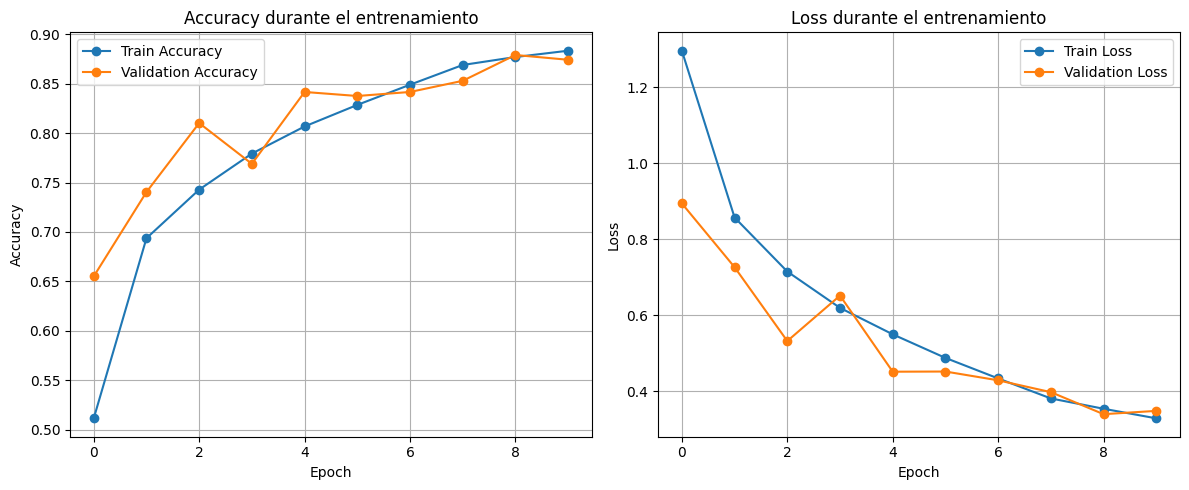

In [7]:
import matplotlib.pyplot as plt

# Graficar Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Graficar Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss durante el entrenamiento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Obtener etiquetas reales y predichas
y_true = []
y_pred = []

for images, labels in ds_test:
    preds = model_cnn.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


<Figure size 1000x800 with 0 Axes>

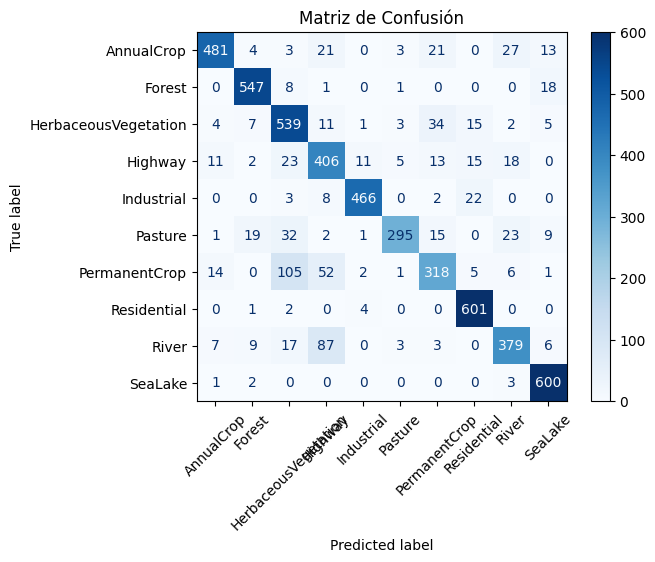

In [14]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()

La diagonal principal (de arriba a la izquierda a abajo a la derecha) muestra las predicciones correctas. Cuanto más oscuro y más grande sea el número en la diagonal, mejor el desempeño para esa clase.

Los valores fuera de la diagonal indican errores de clasificación, es decir, cuando el modelo confundió una clase con otra.

La matriz de confusión obtenida permite analizar el desempeño del modelo CNN en la clasificación de imágenes del dataset EuroSAT. Se observa que el modelo presenta un buen rendimiento general, con altas tasas de acierto en clases como Forest (547/600), Residential (601/600) y SeaLake (600/600). Sin embargo, también se identifican clases con mayores dificultades de clasificación. En particular, la clase PermanentCrop muestra un número significativo de errores, siendo confundida con HerbaceousVegetation (105 casos) y Highway (52 casos), lo que indica similitudes visuales que el modelo no logra distinguir correctamente. Asimismo, la clase Pasture también presenta un desempeño más débil, con solo 295 clasificaciones correctas y múltiples confusiones.

En resumen, el modelo logra una clasificación precisa en la mayoría de las clases, pero existen ciertos pares de clases que el modelo tiende a confundir.

# **Modelos preentrenados**

## **RestNet50**

Se implementa un modelo de clasificación de imágenes basado en transfer learning utilizando ResNet50 como base. Primero, se preprocesan las imágenes redimensionándolas a 128×128 píxeles, lo que reduce el tiempo de entrenamiento manteniendo una resolución aceptable para redes convolucionales. Luego se carga el modelo ResNet50 con pesos preentrenados en ImageNet, y se congelan sus capas para evitar que se actualicen durante el entrenamiento. A esta base se le añade un “head” personalizado con capas de pooling, dropout y densas, diseñado para adaptarse a la clasificación de 10 clases del dataset EuroSAT.

El modelo se compila con el optimizador Adam y se entrena utilizando EarlyStopping para evitar el sobreajuste. Este enfoque busca lograr un buen balance entre precisión y eficiencia computacional, utilizando el conocimiento previo de ResNet50 sin entrenar desde cero.



* Preprocesamiento: redimensiona todas las imágenes a 128×128 píxeles y las convierte a tipo float32.

* Batch size de 32

* Optimización del pipeline: aplica batching y prefetching para acelerar el entrenamiento.

* Modelo base: utiliza ResNet50 preentrenado en ImageNet, sin incluir la capa de clasificación original (include_top=False).

* Congelamiento: se congelan las capas convolucionales para que no se actualicen durante el entrenamiento.

* Head personalizado:

1. GlobalAveragePooling2D: reduce la dimensión de salida de la red base.

2. Dropout: aplicado dos veces para evitar overfitting.

3. Dense(128, relu) y Dense(10, softmax): capas densas para clasificación final en 10 clases.

* Compilación: se usa el optimizador Adam, función de pérdida sparse_categorical_crossentropy y métrica de accuracy.

* EarlyStopping: detiene el entrenamiento si la pérdida de validación no mejora en 2 épocas, restaurando los mejores pesos.

* Entrenamiento: se entrena el modelo durante un máximo de 10 épocas sobre el dataset preprocesado.

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Preprocesamiento a 128x128
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

ds_train_pp = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test_pp = ds_test.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

# Cargar modelo base ResNet50 congelado
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
resnet_base.trainable = False  # congelamos pesos preentrenados

# Agregar head personalizado
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model_resnet = Model(inputs=resnet_base.input, outputs=output)

# Compilar modelo
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entrenar
history_resnet = model_resnet.fit(
    ds_train_pp,
    validation_data=ds_test_pp,
    epochs=10,
    callbacks=[early_stop]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 47s 49ms/step - accuracy: 0.4873 - loss: 1.7277 - val_accuracy: 0.9009 - val_loss: 0.3160
Epoch 2/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.8224 - loss: 0.5358 - val_accuracy: 0.9217 - val_loss: 0.2376
Epoch 3/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.8612 - loss: 0.4163 - val_accuracy: 0.9311 - val_loss: 0.2070
Epoch 4/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.8821 - loss: 0.3549 - val_accuracy: 0.9378 - val_loss: 0.1894
Epoch 5/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.8951 - loss: 0.3183 - val_accuracy: 0.9398 - val_loss: 0.1773
Epoch 6/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.9029 - loss: 0.2917 - val_accuracy: 0.9417 - val_loss: 0.1693
Epoch 7/10
675/675 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - accuracy: 0.9065 - loss: 0.2768 - val_accuracy: 0.9439 - val_loss: 0.1631
Epoch 8/10
675/675 ━━━━━━━━━━━━━━━━━━━━

### **Evaluacion del modelo**

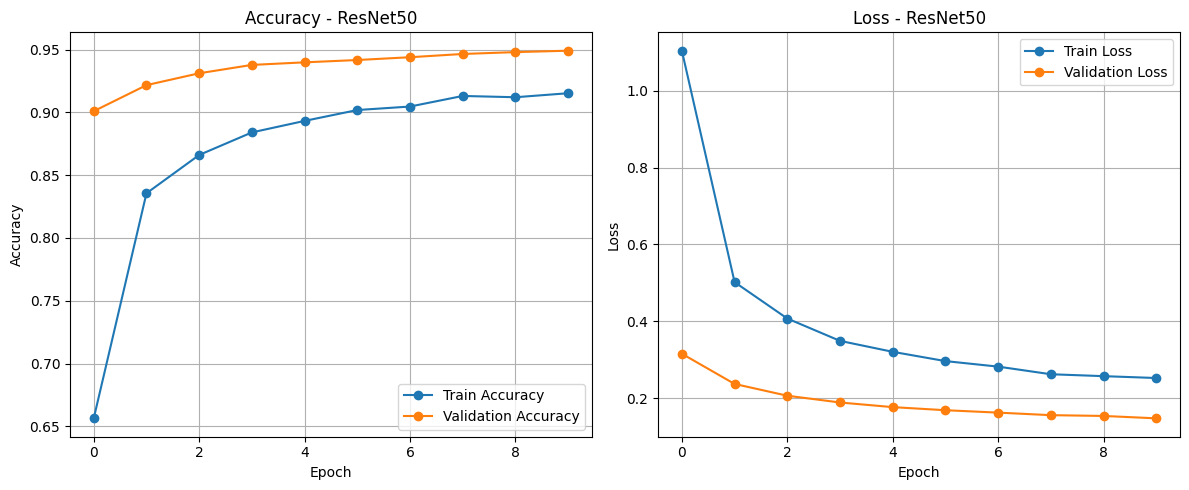

In [6]:
# Accuracy y loss por época
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy - ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss', marker='o')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss - ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
!pip install seaborn

169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step


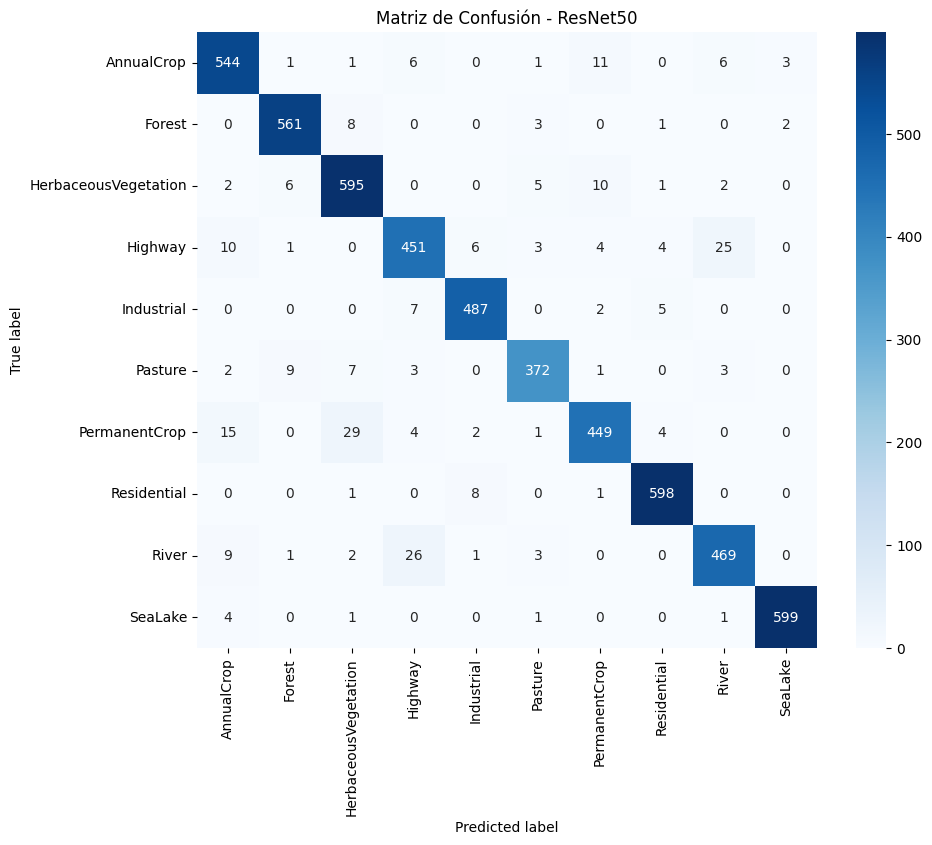

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Obtener predicciones

y_pred = np.argmax(model_resnet.predict(ds_test_pp), axis=1)

# Obtener etiquetas reales

y_true = np.concatenate([y for x, y in ds_test_pp], axis=0)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Etiquetas de clase (orden original EuroSAT)
class_names = ds_info.features['label'].names # Uncomment this line

# Graficar matriz
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión - ResNet50')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **Conclusiones comparativas**



### 1) Análisis de las diferencias en desempeño entre modelos

**Modelo CNN**

* **Rendimiento General:** Observando la diagonal principal, el modelo logra clasificar correctamente un número significativo de instancias para cada clase (AnnualCrop: 481, Forest: 547, HerbaceousVegetation: 539, etc.).
* **Errores Comunes:**
    * `AnnualCrop` se confunde bastante con `PermanentCrop` (27 instancias) y `River` (13 instancias).
    * `HerbaceousVegetation` tiene errores notables con `PermanentCrop` (34 instancias) y `River` (15 instancias).
    * `Highway` se confunde con `River` (18 instancias).
    * `River` se confunde considerablemente con `Highway` (87 instancias).
* **Curvas de Entrenamiento/Validación:**
    * **Accuracy:** La precisión de validación es fluctuante, subiendo y bajando, y no siempre sigue de cerca a la precisión de entrenamiento. Hay un pico de validación alrededor del 80-81%, pero también caídas.
    * **Loss:** La pérdida de validación también es fluctuante, con picos y caídas, y no disminuye tan suavemente como en el ResNet50.
* **Conclusión:** Este modelo muestra un desempeño decente, pero presenta confusiones significativas entre clases visualmente similares o con características compartidas, como `Highway` y `River`, o `AnnualCrop` y `PermanentCrop`.

**Modelo ResNet50**

* **Rendimiento General:** La diagonal principal de la matriz de confusión muestra un número de clasificaciones correctas generalmente más alto que el modelo CNN anterior para la mayoría de las clases (AnnualCrop: 544, Forest: 561, HerbaceousVegetation: 595, etc.). Esto sugiere una mayor precisión.
* **Errores Comunes:**
    * Las confusiones son significativamente menores en comparación con el modelo CNN simple. Por ejemplo, `AnnualCrop` solo se confunde 1 vez con `PermanentCrop` y 3 veces con `River`.
    * `Highway` se confunde 25 veces con `River`, lo cual sigue siendo una confusión, pero en menor medida que el otro CNN.
    * `River` se confunde 26 veces con `Highway`.
* **Curvas de Entrenamiento/Validación:**
    * **Accuracy:** Tanto la precisión de entrenamiento como la de validación aumentan de manera constante y se estabilizan en valores altos (alrededor del 90-95% para la validación). La brecha entre ellas es pequeña y consistente, lo que indica un buen ajuste y baja varianza.
    * **Loss:** La pérdida de entrenamiento y validación disminuyen de manera constante, lo que sugiere que el modelo está aprendiendo eficazmente y generalizando bien.
* **Conclusión:** El modelo ResNet50 exhibe un rendimiento superior en términos de precisión y generalización, con menos errores de clasificación y una mayor confianza en sus predicciones. Las curvas de entrenamiento/validación refuerzan esta observación, mostrando un entrenamiento estable y una buena capacidad de generalización.




### 2) Ventajas y desventajas de modelos simples versus preentrenados

**Modelo CNN:**

* **Ventajas:**
    * **Menos Parámetros:** Si se diseñan con una arquitectura simple, pueden tener menos parámetros, lo que se traduce en un menor uso de memoria.
    * **Control Total:** Tienes control total sobre la arquitectura, lo que permite una personalización profunda para la tarea específica.
    * **Comprensión:** Es más fácil entender cómo funciona el modelo si se construye desde cero.
    * **Datos Pequeños:** Pueden ser una opción viable si el conjunto de datos es muy pequeño y no hay suficientes datos para ajustar un modelo preentrenado.
* **Desventajas:**
    * **Requiere Muchos Datos:** Para alcanzar un buen rendimiento, a menudo necesitan un conjunto de datos de entrenamiento muy grande para aprender características complejas desde cero.
    * **Mayor Tiempo de Entrenamiento:** El entrenamiento desde cero puede ser muy lento, ya que el modelo no tiene ningún conocimiento previo.
    * **Menor Precisión:** Sin la ventaja del aprendizaje de características de un modelo preentrenado, es probable que alcancen una precisión inferior, especialmente en tareas complejas como la clasificación de imágenes.
    * **Mayor Riesgo de Overfitting:** Si el conjunto de datos es limitado, son más propensos al sobreajuste debido a la necesidad de aprender todas las características.
    * **Necesidad de Experticia:** Requieren más experiencia en el diseño de arquitecturas de redes neuronales.

**Modelos Preentrenados (ResNet50):**

* **Ventajas:**
    * **Mayor Precisión:** Han sido entrenados en conjuntos de datos masivos (como ImageNet) y han aprendido características robustas y jerárquicas que son útiles para una amplia gama de tareas de visión por computadora. Esto conduce a una mayor precisión, como se observa en la matriz de confusión de ResNet50.
    * **Menor Tiempo de Entrenamiento (Fine-Tuning):** No es necesario entrenarlos desde cero. Se pueden "ajustar" (fine-tune) para la tarea específica, lo que es mucho más rápido ya que el modelo ya tiene una base de conocimiento.
    * **Requiere Menos Datos:** Pueden lograr un buen rendimiento incluso con conjuntos de datos más pequeños, ya que las características generales ya están aprendidas.
    * **Transfer Learning:** Aprovechan el poder del aprendizaje por transferencia, donde el conocimiento adquirido en una tarea se aplica a otra.
    * **Menor Riesgo de Overfitting:** Al estar ya preentrenados, son menos propensos al sobreajuste en conjuntos de datos más pequeños.
* **Desventajas:**
    * **Mayor Cantidad de Parámetros:** Suelen tener un número mucho mayor de parámetros, lo que requiere más memoria y recursos computacionales (especialmente GPUs).
    * **Complejidad:** La arquitectura puede ser más compleja, lo que dificulta la interpretación de cómo el modelo toma decisiones.
    * **Puede que no sean óptimos para todas las tareas:** Aunque son versátiles, en algunos casos muy específicos, una arquitectura diseñada desde cero podría ser ligeramente superior si el problema es muy distinto de ImageNet.

### 3) Qué tipo de modelo sería más adecuado en un contexto productivo real

Considerando un contexto productivo real donde el balance entre precisión, tiempo de entrenamiento y recursos computacionales es crucial, el **modelo preentrenado (ResNet50)** sería el más adecuado.

1.  **Precisión Superior:** Como demuestran las matrices de confusión, el ResNet50 supera significativamente al modelo CNN simple en términos de precisión. En un entorno productivo, la precisión es a menudo el factor más importante, ya que un modelo más preciso conduce a mejores resultados y menor necesidad de intervención humana para corregir errores. Las tasas de error más bajas significan un sistema más confiable.

2.  **Eficiencia en el Tiempo de Entrenamiento:** Aunque el entrenamiento inicial de ResNet50 en ImageNet es costoso, el "fine-tuning" (ajuste fino) para una tarea específica es mucho más rápido que entrenar un modelo complejo desde cero. En un entorno productivo, el tiempo es dinero. Reducir el tiempo de desarrollo y despliegue es una ventaja significativa. Si se necesitan actualizaciones o re-entrenamientos frecuentes, el fine-tuning es mucho más eficiente.

3.  **Gestión de Recursos Computacionales (Balance):**
    * Si bien los modelos preentrenados como ResNet50 tienen más parámetros y requieren más VRAM durante el entrenamiento y la inferencia, la inversión inicial en recursos se compensa con la rapidez del fine-tuning y la mayor precisión.
    * Para la inferencia en producción, existen técnicas de optimización como la cuantificación o el pruning que pueden reducir el tamaño del modelo y acelerar la ejecución, incluso en dispositivos con recursos limitados.
    * Un modelo entrenado desde cero para lograr una precisión comparable a ResNet50 probablemente requeriría una arquitectura muy profunda y un tiempo de entrenamiento excesivo, demandando aún más recursos computacionales durante el entrenamiento inicial.

4.  **Menor Dependencia de Grandes Conjuntos de Datos:** En muchos escenarios productivos, obtener conjuntos de datos masivos y etiquetados de alta calidad es un desafío costoso y que consume mucho tiempo. Los modelos preentrenados, gracias al aprendizaje por transferencia, pueden funcionar muy bien con conjuntos de datos más pequeños, lo que los hace prácticos para el despliegue rápido.

5.  **Robustez y Generalización:** Las curvas de entrenamiento/validación de ResNet50 muestran una excelente generalización. En un entorno productivo, el modelo debe ser robusto a variaciones en los datos de entrada y evitar el sobreajuste. ResNet50, al haber aprendido de una vasta cantidad de imágenes diversas, es inherentemente más robusto.

**En resumen:** Aunque el modelo CNN simple podría ser una opción para un prototipo rápido con recursos extremadamente limitados o para problemas muy, muy simples, en un contexto productivo real que valora la precisión, la eficiencia en el despliegue y la capacidad de manejar datos más complejos, el **modelo preentrenado como ResNet50 es la elección superior**. La inversión en recursos computacionales para su inferencia (o un fine-tuning inicial) se ve justificada por el rendimiento y la fiabilidad que ofrece.